# Amadeus Data Science Hiring Test Report

This notebook will be my report for the hiring test of Amadeus. For further infrmation, do not hesitate to contact me at [louis.auneau@amadeus.com](mailto:louis.auneau@amadeus.com).

## Abstract

Todo

## Content

[1. Introduction](#1.-Introduction)  
[2. Methods & results](#2.-Methods-&-results)  
...... [2.1 Data collection](#2.1-Data-collection)  
...... [2.2 Data cleaning and pre-processing](#2.2-Data-cleaning-and-pre-processing)  
...... [2.3 Descriptive Analysis](#2.3-Descriptive-Analysis)  
............ [2.3.1 General tendencies](#2.3.1-General-tendencies)  
............ [2.3.2 Products offered](#2.3.2-Products-offered)  
............ [2.3.3 Best selling product overall](#2.3.3-Best-selling-product-overall)  
...... [2.4 Predictive Models](#2.4-Predictive-Models)  
............ [2.4.1 ARIMA](#2.4.1-ARIMA)  
............ [2.4.2 Random Forests](#2.4.2-Random-Forests)  
[3. Discussion and feedback](#3.-Discussion-and-feedback)  
[4. Resources](#4.-Resources)  

## 1. Introduction

Todo

## 2. Methods & results

### 2.1 Data collection

Let's start by loading all CSVs and display first rows to get a better grasp of the data.

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from IPython.display import display

demographic = pd.read_csv("data/demographic.csv")
products = pd.read_csv("data/product.csv")
transactions = pd.read_csv("data/transaction_data.csv")

In [2]:
display(demographic.head())
display(products.head())
display(transactions.head())

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


### 2.2 Data cleaning and pre-processing

#### 2.2.1 Null values

First, we need to check empty values for `DAY`, `WEEK_NO`, `TRANS_TIME`, `SALES_VALUE` and `QUANTITY` columns of the `transactions` dataset, as it will be the columns we are going to manipulate for this project.

In [81]:
transactions.isnull().sum()

household_key        0
BASKET_ID            0
DAY                  0
PRODUCT_ID           0
QUANTITY             0
SALES_VALUE          0
STORE_ID             0
RETAIL_DISC          0
TRANS_TIME           0
WEEK_NO              0
COUPON_DISC          0
COUPON_MATCH_DISC    0
DATETIME             0
dtype: int64

There are no null values, so we don't need to replace any value.  
  
#### 2.2.2 Datetime generation
Then, ss our ARIMA model will be a timeserie forcasting model, transforming the transactions' week, day and time into a proper datetime object is necessary. We lack precise dates, so we will choose a baseline date (*1/1/1900*, python's baseline date) and assume transactions started on that day. Regarding transactions' time, it was represented as an integer, with thousands and hundreds used to encode hours, and tens and units used to encode minutes. We are going to parse it and include it in the datetime. This function may take a few minutes to be executed as the task is repeated for all transactions.

In [80]:
def parse_datetime(transaction):
    """
    Takes a transaction row from the `transaction_data.csv` file, and uses `TRANS_TIME` and `DAY` columns to create a datetime object.
    """
    time = transaction["TRANS_TIME"]
    
    if len(time) == 1:
        time = '000'+ time
    elif len(time) == 2: #len being O(1) in python it's ok tu use it twice
        time = '00' + time
        
    return datetime.strptime(time, '%H%M') + timedelta(days=transaction["DAY"] - 1) # (-1 as the `DAY` column is 1 indexed)

In [38]:
transactions["TRANS_TIME"] = transactions["TRANS_TIME"].astype(str) # We need to cast transaction times to avoid automatic coercion by python.
transactions["DATETIME"] = transactions.apply(parse_datetime, axis=1)
display(transactions.head())

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,DATETIME
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0,1900-01-01 16:31:00
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0,1900-01-01 16:31:00
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0,1900-01-01 16:31:00
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0,1900-01-01 16:31:00
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0,1900-01-01 16:31:00


#### 2.2.3 Sales value timeserie creatiom

The datetime we generated allows us to create a timeserie (as a *Pandas Serie*). We will also use a day scale, which allows us to keep a really good precision, while reducing greatly the size of the data handled by our future models.

In [92]:
sales_ts = transactions.set_index('DATETIME').groupby(pd.Grouper(freq='D'))['SALES_VALUE'].sum()

display(sales_ts.head())
transactions.shape[0]/sales_ts.count()

DATETIME
1900-01-01     549.31
1900-01-02     458.91
1900-01-03    1560.37
1900-01-04    1785.64
1900-01-05     856.93
Freq: D, Name: SALES_VALUE, dtype: float64

3625.384047267356

We can see that we divided our timeserie size by 3625.

### 2.3 Descriptive Analysis

#### 2.3.1 General tendencies

Let's start by plotting our sales timeserie.

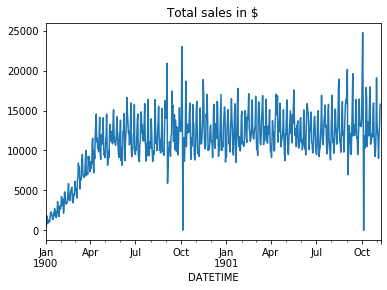

In [93]:
sales_ts.plot(title="Total sales in $")

We already see some trends : 
- Sales aren't stationnary over the first few month. This can have an influence on our models (particularly the ARIMA Model). This might be due to a business size growth, not correlated to intrinsict sales growth,
- on the other hand, sales are quite stationary afterwards,
- sales reach a peak on the 10th month, and a year after, which may indicate some seasonality.

We can also get basic descriptive statistics about transactions and daily sales values in order to better grasp our dataset. Products and demographic datasets having mainly qualitative columns, there are not really interesting.

In [95]:
transactions.describe()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
count,2.454385e+06,2.454385e+06,2.454385e+06,2.454385e+06,2.454385e+06,2.454385e+06,2.454385e+06,2.454385e+06,2.454385e+06,2.454385e+06,2.454385e+06
mean,1.271389e+03,3.356323e+10,3.711756e+02,2.843705e+06,1.004824e+02,3.099640e+00,3.070255e+03,-5.405539e-01,5.370973e+01,-1.637147e-02,-2.902686e-03
std,7.264514e+02,4.420506e+09,1.799599e+02,3.759551e+06,1.153284e+03,4.200936e+00,8.821958e+03,1.250090e+00,2.570724e+01,2.169416e-01,3.973536e-02
min,1.000000e+00,2.698485e+10,1.000000e+00,2.567100e+04,0.000000e+00,0.000000e+00,1.000000e+00,-1.800000e+02,1.000000e+00,-5.593000e+01,-7.700000e+00
25%,6.550000e+02,3.014209e+10,2.200000e+02,9.170310e+05,1.000000e+00,1.280000e+00,3.300000e+02,-6.900000e-01,3.200000e+01,0.000000e+00,0.000000e+00
50%,1.271000e+03,3.255587e+10,3.740000e+02,1.027808e+06,1.000000e+00,2.000000e+00,3.700000e+02,-3.000000e-02,5.400000e+01,0.000000e+00,0.000000e+00
75%,1.914000e+03,3.563836e+10,5.270000e+02,1.132770e+06,1.000000e+00,3.490000e+00,4.220000e+02,0.000000e+00,7.600000e+01,0.000000e+00,0.000000e+00
max,2.500000e+03,4.184806e+10,6.770000e+02,1.812030e+07,8.963800e+04,8.400000e+02,3.428000e+04,3.990000e+00,9.700000e+01,0.000000e+00,0.000000e+00


In [96]:
sales_ts.describe()

count      677.000000
mean     11237.386352
std       3708.901581
min          2.990000
25%       9848.050000
50%      11498.840000
75%      13435.840000
max      24760.100000
Name: SALES_VALUE, dtype: float64

Among interesting values, we have :
- Total transactions : **2454385**
- Total days in dataset : **677**
- Mean sale value per transaction : \$**3.099640**  
- Standard Deviation on sale value per transaction : \$**4.200936**  
- Mean daily revenue : \$**11237.386352**  
- Standard daily revenue deviation : \$**3708.901581**  

And finally the sales per day distribution :

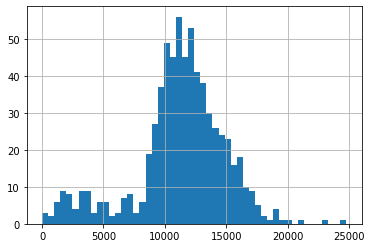

In [99]:
sales_ts.hist(bins=50)

#### 2.3.2 Products offered

How many products are offered by the store on week 50 ? In order to answer this question we have to : 
- Filter all transactions done on week 50,
- List all product IDs for those transactions,
- Count how many unique product IDs we have.

In [24]:
transactions.loc[transactions['WEEK_NO'] == 50]['PRODUCT_ID'].nunique()

11861

This gives us a total of **11861** products bought on week 50. 

#### 2.3.3 Best selling product overall

Let's consider, both best selling products in terms of units sold, and in terms of revenue generate.  
  
First, in order to find the best selling product, we need to group transactions by product IDs (`PRODUCT_ID`). And then, in order to get 
- the best selling in terms of units, sum `QUANTITY` for each product and get the top one,
- the one generating the most revenue, sum `SALES_VALUE` for each product and get the top one.

In [101]:
transactions_per_products = transactions.groupby('PRODUCT_ID');

# Per units sold
best_unit_selling_products = transactions_per_products['QUANTITY'].sum().sort_values(ascending=False)
best_unit_selling_product_id = best_unit_selling_products.index[0]
overall_amount_sold = best_unit_selling_products.values[0]
print('Best selling product is product ' + str(product_id) + ', sold ' + str(overall_amount_sold) + ' times overall.')

# Per revenue generated
best_selling_products = transactions_per_products['SALES_VALUE'].sum().sort_values(ascending=False)
best_selling_product_id = best_selling_products.index[0]
overall_revenue_generated = best_selling_products.values[0]
print('Best selling product is product ' + str(product_id) + ', generating $' + str(overall_revenue_generated) + ' overall.')

Best selling product is product 6534178, sold 204770364 times overall.
Best selling product is product 6534178, generating $477754.4900000089 overall.


Product **6534178** is both the most sold per units and the one generating the most revenue. We can get further information about the product by looking into the products dataframe :

In [102]:
products.loc[products['PRODUCT_ID'] == product_id]

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
57221,6534178,69,KIOSK-GAS,Private,COUPON/MISC ITEMS,GASOLINE-REG UNLEADED,


The best selling product is product number **6534178**, which is *Regular Gasoline*. It was sold **204770364** times overall and generated **\$477754.49** in total. The total quantity sold seems really large with regards for the total number of transactions. Let's have a deeper look by computing the median quantity sold by transactions:

In [71]:
transactions.loc[transactions["PRODUCT_ID"] == product_id]["QUANTITY"].median()

10535.5

With a median *10535 units* sold per gas transaction, we can think that gasoline is probably sold by thousandths of gallon, which explains the large quantity sold.

### 2.4 Predictive Models

#### 2.4.1 ARIMA

Autocorreletion analysis
We consider sales values in function of time. To have a better view for our autocorreletion plot, let's use a weekly interval.

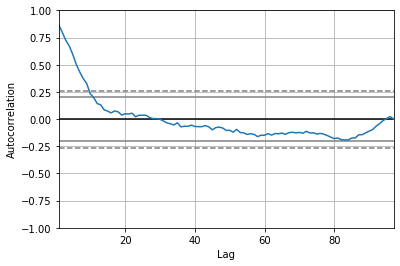

In [78]:
sales = transactions.set_index('DATETIME').groupby(pd.Grouper(freq='W'))['SALES_VALUE'].sum()
pd.plotting.autocorrelation_plot(sales)

#### 2.4.2 Random Forests

## 3. Discussion and feedback

## 4. Resources